In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/University/Code/CNN practice/datasetFull

Mounted at /content/drive
/content/drive/MyDrive/University/Code/CNN practice/datasetFull


# Classifier Report

In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ploat_ROC(y_true, y_score, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 5))
  colors = ['blue', 'red', 'green']
  for i, color in zip(range(y_score.shape[1]), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title( title +' (one-vs-rest)')
  plt.legend(loc="lower right")
  plt.show()

def ploat_confusionMatrix(y_true, y_predict, title):
  conf_mat = confusion_matrix(y_true, y_predict)
  # print("Confusion matrix:\n", conf_mat)

  # Print confusion matrix as heatmap
  sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

def ploat_AUC(y_true, y_score, title):
  n_classes = y_score.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  # Compute ROC curve and ROC area for each class
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves
  plt.figure()
  lw = 2
  colors = ['darkorange', 'cornflowerblue', 'purple']
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (AUC = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for ' + title )
  plt.legend(loc="lower right")
  plt.show()


def ploat_AUC_per_class(y_true, y_score, title):
  # compute AUC for each class
  n_classes = y_score.shape[1]
  auc_list = []
  for i in range(n_classes):
      auc = roc_auc_score(y_true == i, y_score[:, i])
      auc_list.append(auc)

  # plot AUC curve for class 0
  fpr, tpr, _ = roc_curve(y_true == 0, y_score[:, 0])
  plt.plot(fpr, tpr, label='Class 0 (AUC = %0.2f)' % auc_list[0])

  # set plot properties
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")

  plt.show()

def classificationReport(y_true, y_pred, title):
  print('Classification report for ' + title)
  print('\n')
  target_names = ['class 0', 'class 1', 'class 2']
  print(classification_report(y_true, y_pred, target_names=target_names))

# Augment

In [3]:
import os
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.layers import Reshape
from keras import regularizers
from pathlib import Path
import numpy as np

In [4]:
BATCH_SIZE = 32
train_generator = ImageDataGenerator(rotation_range=45,
                                     brightness_range=[0.1, 0.9],
                                     width_shift_range=0.1,
                                     height_shift_range=0.15,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     shear_range=20.0,
                                     validation_split=0.30,
                                     fill_mode='nearest',
                                     featurewise_center=False,
                                     samplewise_center=False,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_dir = 'train'
test_data_dir = 'test'
validation_data_dir = 'Validation'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,
                                               #subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(validation_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,
                                               #subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 983 images belonging to 3 classes.
Found 108 images belonging to 3 classes.
Found 108 images belonging to 3 classes.


In [6]:
def create_model(input_shape, n_classes=3, optimizer='rmsprop', fine_tune=0):
    base = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        classes=n_classes,
        pooling='max',
        classifier_activation="softmax",
    )

    # Optionally, freeze some layers during fine-tuning
    # if fine_tune > 0:
    #     for layer in base.layers[:-fine_tune]:
    #         layer.trainable = False

    top_model = base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=base.input, outputs=output_layer)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [7]:
!pip install livelossplot --quiet
from livelossplot.inputs.keras import PlotLossesCallback

tl_checkpoint = ModelCheckpoint(filepath='model_vgg16.hdf5',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=50,
                           restore_best_weights=True,
                           mode='min')

In [10]:
input_shape = (224, 224, 3)
n_classes=3

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 100

optimizer = Adam(learning_rate=0.0001)

# compile the model, 3 layers unfrozen for Fine-Tuning
vgg16_model_ft = create_model(input_shape, n_classes, optimizer, fine_tune=0)

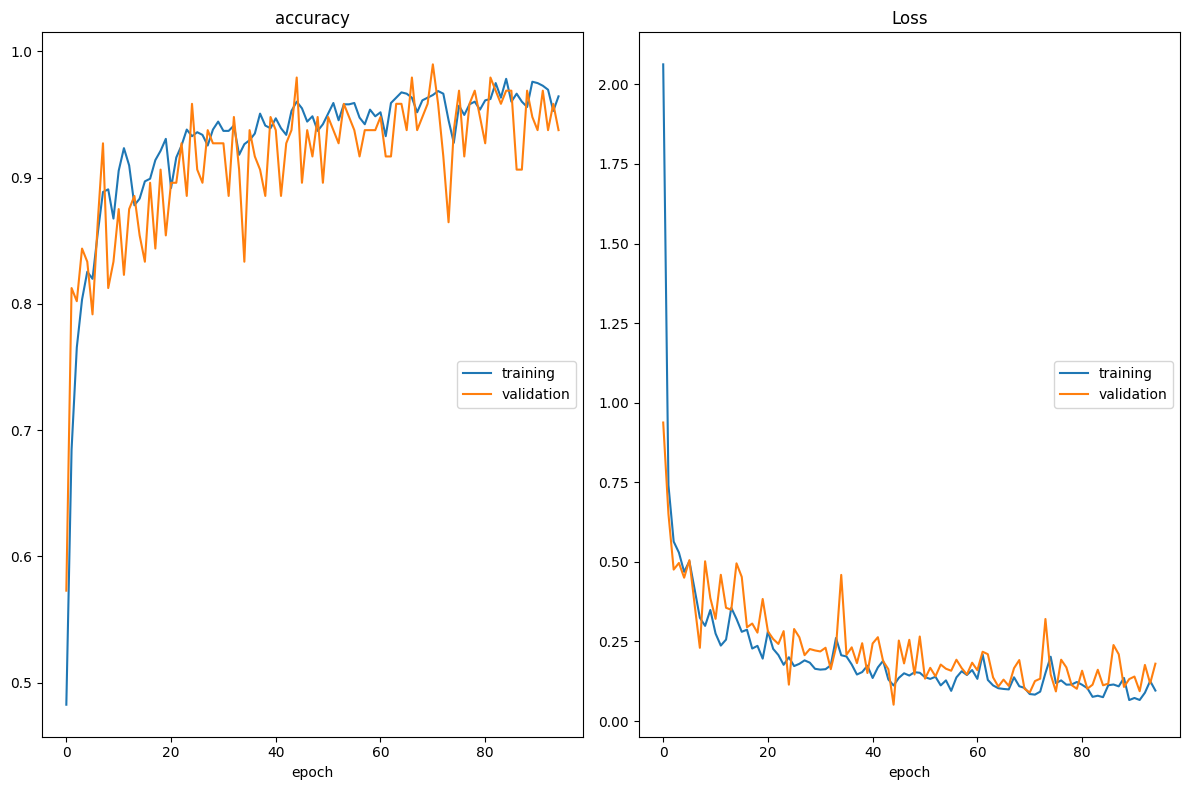

accuracy
	training         	 (min:    0.483, max:    0.978, cur:    0.964)
	validation       	 (min:    0.573, max:    0.990, cur:    0.938)
Loss
	training         	 (min:    0.066, max:    2.063, cur:    0.096)
	validation       	 (min:    0.051, max:    0.938, cur:    0.180)
30/30 [==============================] - 29s 960ms/step - loss: 0.0959 - accuracy: 0.9642 - val_loss: 0.1803 - val_accuracy: 0.9375
CPU times: user 54min 51s, sys: 1min 14s, total: 56min 6s
Wall time: 1h 5min 7s


In [11]:
%%time

plot_loss = PlotLossesCallback()

ConvNeXtLarge_ft_history = vgg16_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint, early_stop, plot_loss],
                                  verbose=1)

In [12]:
# Generate predictions
vgg16_model_ft.load_weights('model_vgg16.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg16_preds_ft = vgg16_model_ft.predict(testgen)
vgg16_pred_classes_ft = np.argmax(vgg16_preds_ft, axis=1)

108/108 [==============================] - 74s 677ms/step


In [13]:
from sklearn.metrics import accuracy_score

vgg16_acc_ft = accuracy_score(true_classes, vgg16_pred_classes_ft)
print("VGG16 Accuracy withOut Fine-Tuning {:.2f}%".format(vgg16_acc_ft * 100))

VGG16 Accuracy withOut Fine-Tuning 93.52%


Classification report for VGG16


              precision    recall  f1-score   support

     class 0       0.96      0.92      0.94        53
     class 1       0.88      0.88      0.88        26
     class 2       0.94      1.00      0.97        29

    accuracy                           0.94       108
   macro avg       0.93      0.94      0.93       108
weighted avg       0.94      0.94      0.93       108





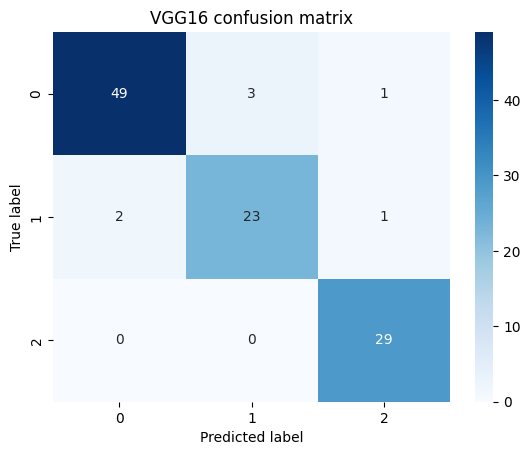

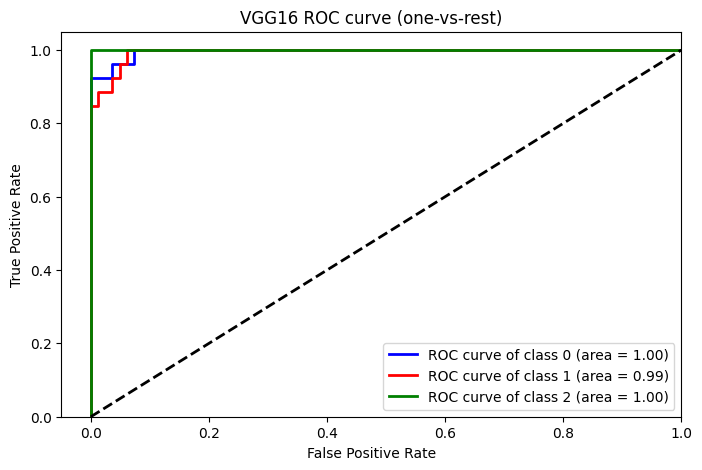

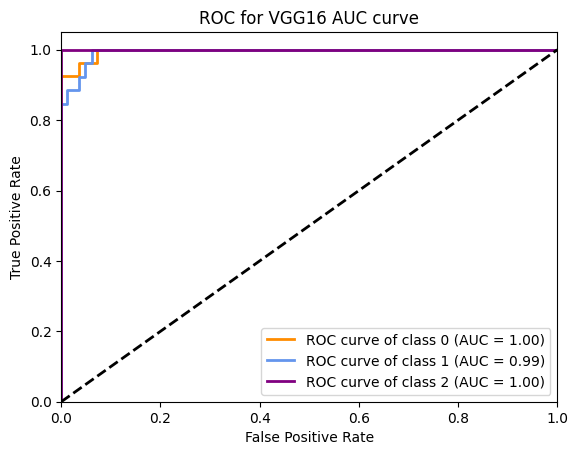

In [14]:
classificationReport(true_classes, vgg16_pred_classes_ft, 'VGG16')
print('\n')
ploat_confusionMatrix(true_classes, vgg16_pred_classes_ft, 'VGG16 confusion matrix')
print('\n')
ploat_ROC(true_classes, vgg16_preds_ft, "VGG16 ROC curve")
print('\n')
ploat_AUC(true_classes, vgg16_preds_ft, "VGG16 AUC curve")